In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cupy as cp
%matplotlib inline

cp.cuda.Device(1).use()

<CUDA Device 1>

# Init data sizes and parametes of the PXM of ID16A

In [2]:
ntheta = 180  # number of angles (rotations)
n = 384
pn = 384  # tomography chunk size for GPU processing
ptheta = 180  # holography chunk size for GPU processing

center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n  # object voxel size
energy = 33.35  # [keV] xray energy
focusToDetectorDistance = 1.28
ndist = 3
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/magnifications2[0]  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

## Read data

In [3]:
data = np.zeros([ndist,ntheta,n,n],dtype='float32')
ref = np.zeros([1,n,n],dtype='float32')

for k in range(ndist):
    data[k] = dxchange.read_tiff(f'data/modeling/data_chip_{n}_{k}.tiff')[:ntheta]
ref[:] = dxchange.read_tiff(f'data/modeling/ref_chip_{n}_0.tiff')
shifts = np.load('shifts.npy')[:ndist,:ntheta]

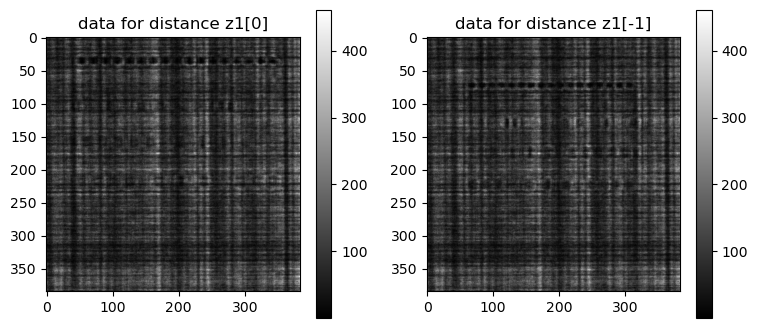

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(data[0,0],cmap='gray')
axs[0].set_title('data for distance z1[0]')
fig.colorbar(im)
im=axs[1].imshow(data[-1,-1],cmap='gray')
axs[1].set_title('data for distance z1[-1]')
fig.colorbar(im)


## Create a solver class for holography

In [5]:
pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications,distances2)

note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Adjoint test

In [6]:
arr1 = np.pad(np.array(data[0]+1j*data[0]).astype('complex64'),((0,0),(n//2,n//2),(n//2,n//2)),'symmetric')
prb1 = np.array(ref[:]+1j*ref[:]).astype('complex64')
shifts_ref = shifts/norm_magnifications[:,np.newaxis,np.newaxis]
print(arr1.shape,prb1.shape,shifts_ref.shape)
arr2 = pslv.fwd_holo_batch(arr1,prb1, shifts_ref)
arr3 = pslv.adj_holo_batch(arr2,prb1, shifts_ref)
prb3 = pslv.adj_holo_prb_batch(arr2,arr1, shifts_ref)


print(np.sum(arr1*np.conj(arr3)))
print(np.sum(arr2*np.conj(arr2)))
print(np.sum(prb1*np.conj(prb3)))

(180, 768, 768) (1, 384, 384) (3, 180, 2)


(4.333309e+16+798307700j)
(4.333322e+16-84238.27j)
(4.3333153e+16-160038910j)


## $\ \sum_j\sum_i||\mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_j S_{r_{ij}}\psi_i))|-\sqrt{\text{I}_{ij}}\|^2_2\to \text{min}_{\psi_i,q}$ 

data_ref.shape=(1, 1, 384, 384),rec.shape=(1, 768, 768),rec_prb.shape=(1, 384, 384),data_ref.shape=(1, 1, 384, 384),shifts_ref.shape=(1, 1, 2)
0) gammaprb=1, err=8.73986e-05


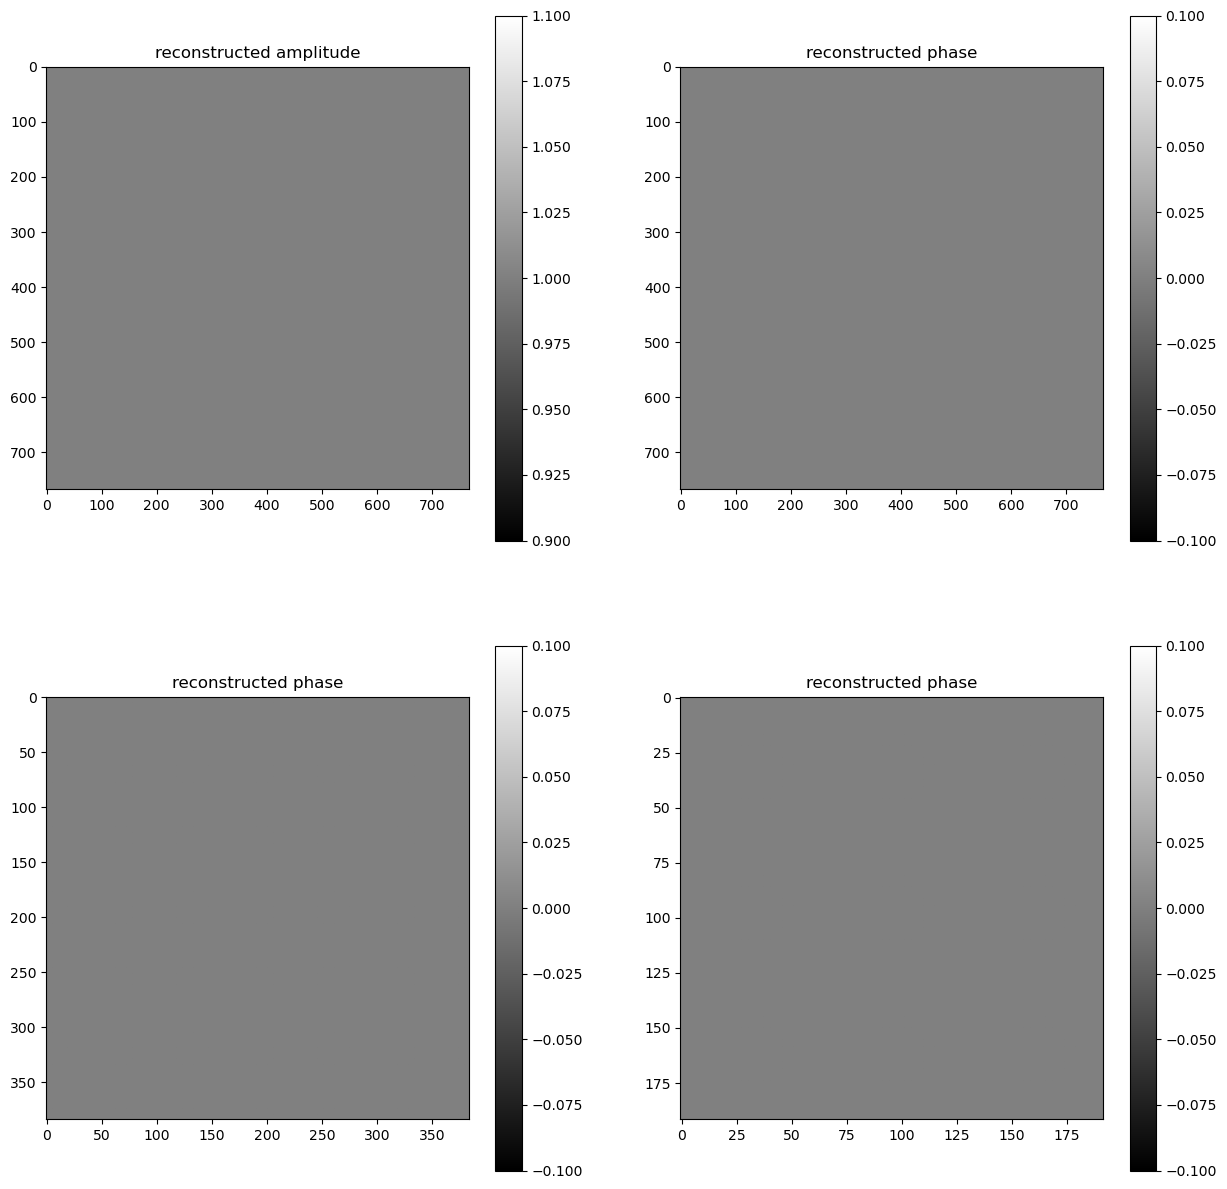

32) gammaprb=1, err=1.27824e-06
64) gammaprb=1, err=7.57552e-07
96) gammaprb=1, err=7.46207e-07
128) gammaprb=1, err=8.80493e-07
160) gammaprb=1, err=1.22801e-06
192) gammaprb=1, err=7.61429e-07
224) gammaprb=1, err=8.36581e-07


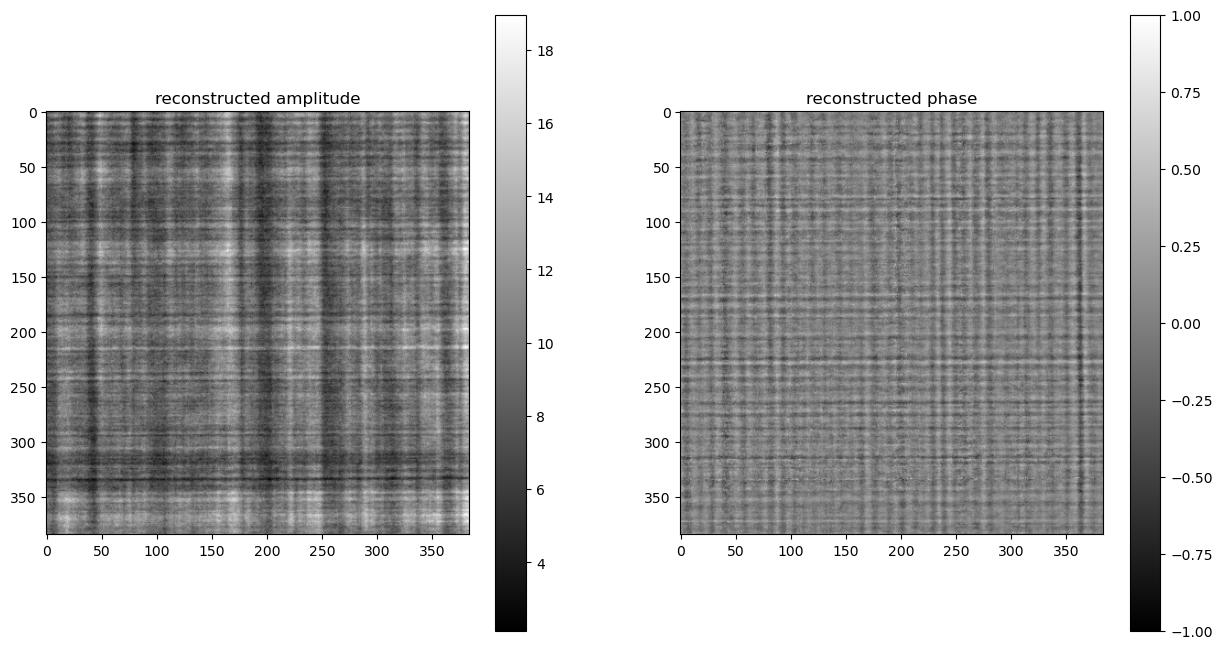

In [7]:
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while(minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma
    
def cg_holo(pslv, data, init, init_prb,  piter,shifts, upd_psi=True, upd_prb=False,step=1,vis_step=1):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(fpsi):
        f = cp.linalg.norm(cp.abs(fpsi)-cp.sqrt(data))**2            
        # f = cp.linalg.norm(cp.abs(fpsi)**2-data)**2            
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    
    for i in range(piter):
        if upd_psi:
            
            fpsi = pslv.fwd_holo(psi,prb,shifts)            
            grad = pslv.adj_holo(fpsi-cp.sqrt(data)*cp.exp(1j*cp.angle(fpsi)), prb,shifts)/cp.max(cp.abs(prb))**2#/ndist**2
                    
            d = -grad    
            # line search
            fd = pslv.fwd_holo(d, prb,shifts)
            gammapsi = line_search(minf, 1, fpsi, fd)
            psi = psi+gammapsi*d
            
            if i%step==0:      
                fpsi = pslv.fwd_holo(psi,prb,shifts)                            
                err=minf(fpsi)                              
                print(f'{i}) {gammapsi=}, {err=:1.5e}')    
           
        if upd_prb:
            fprb = pslv.fwd_holo(psi,prb,shifts)
            gradprb = pslv.adj_holo_prb(fprb-cp.sqrt(data)*cp.exp(1j*cp.angle(fprb)),psi,shifts)/cp.max(cp.abs(psi))**2/pslv.ntheta#/ndist**2

            dprb = -gradprb
            # gradprb0 = gradprb
            # line search
            fdprb = pslv.fwd_holo(psi, dprb,shifts)
            gammaprb = line_search(minf, 1, fprb, fdprb)
            prb = prb + gammaprb*dprb
            
            if i%step==0:
                fprb = pslv.fwd_holo(psi,prb,shifts)
                err=minf(fprb)
                print(f'{i}) {gammaprb=}, {err=:1.5e}')  
        
        if i%vis_step==0:  
            fig, axs = plt.subplots(2, 2, figsize=(15, 15))
            im=axs[0,0].imshow(np.abs(psi[0].get()),cmap='gray')
            axs[0,0].set_title('reconstructed amplitude')
            fig.colorbar(im)
            im=axs[0,1].imshow(np.angle(psi[0].get()),cmap='gray')
            axs[0,1].set_title('reconstructed phase')
            fig.colorbar(im)
            im=axs[1,0].imshow(np.angle(psi[0,n//2:-n//2,n//2:-n//2].get()),cmap='gray')
            axs[1,0].set_title('reconstructed phase')
            fig.colorbar(im)
            im=axs[1,1].imshow(np.angle(psi[0,n//2+n//4:-n//2-n//4,n//2+n//4:-n//2-n//4].get()),cmap='gray')
            axs[1,1].set_title('reconstructed phase')
            fig.colorbar(im)
            plt.show()
        
    return psi,prb

def cg_holo_batch(pslv, data, init, prb_init, piter,shifts=None,upd_psi=True,upd_prb=False,step=1,vis_step=1):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, 2*pslv.n, 2*pslv.n], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)                
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        init_gpu = cp.array(init[ids])
        
        # Radon transform
        res_gpu,res_prb_gpu = cg_holo(pslv, data_gpu, init_gpu,prb_init_gpu, piter,shifts,upd_psi, upd_prb,step,vis_step)
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb

rec = np.ones([1,2*n,2*n],dtype='complex64')
rec_prb = np.ones([1,n,n],dtype='complex64')        
data_ref = ref[:1,np.newaxis]
shifts_ref = cp.array(shifts/norm_magnifications[:,np.newaxis,np.newaxis])[:1,:1]*0

print(f'{data_ref.shape=},{rec.shape=},{rec_prb.shape=},{data_ref.shape=},{shifts_ref.shape=}')

pslv = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances[:1], norm_magnifications[:1], distances2[:1]) 
_,rec_prb = cg_holo_batch(pslv, data_ref, rec, rec_prb, 256, shifts_ref, False,True,32,10000)

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(rec_prb[0]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec_prb[0]),cmap='gray',vmin=-1,vmax=1)
axs[1].set_title('reconstructed phase')
fig.colorbar(im)


(3, 180, 384, 384) (180, 768, 768) (3, 180, 2) (3,)
0) gammapsi=1, err=5.33632e+06


0) gammaprb=1, err=5.30173e+06


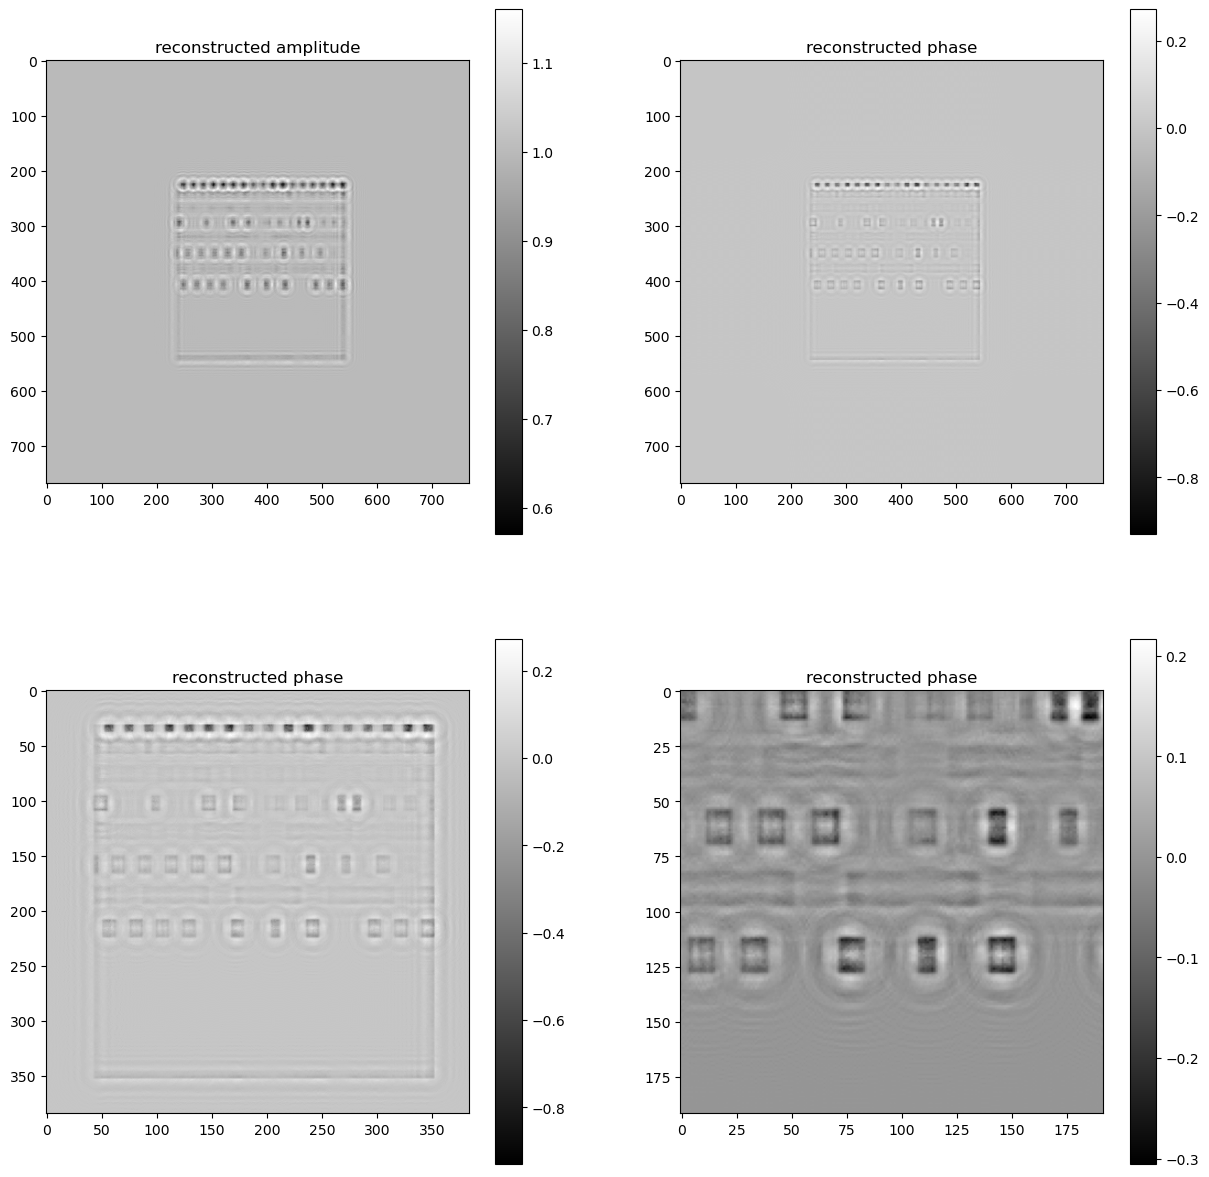

32) gammapsi=1, err=7.44530e+05
32) gammaprb=1, err=7.42058e+05
64) gammapsi=1, err=5.28339e+05
64) gammaprb=1, err=5.26974e+05
96) gammapsi=1, err=4.01283e+05
96) gammaprb=1, err=4.00218e+05
128) gammapsi=1, err=3.10429e+05
128) gammaprb=1, err=3.09590e+05
160) gammapsi=1, err=2.43091e+05
160) gammaprb=1, err=2.42455e+05
192) gammapsi=1, err=1.93852e+05
192) gammaprb=1, err=1.93400e+05
224) gammapsi=1, err=1.58414e+05
224) gammaprb=1, err=1.58091e+05
256) gammapsi=1, err=1.32580e+05
256) gammaprb=1, err=1.32341e+05


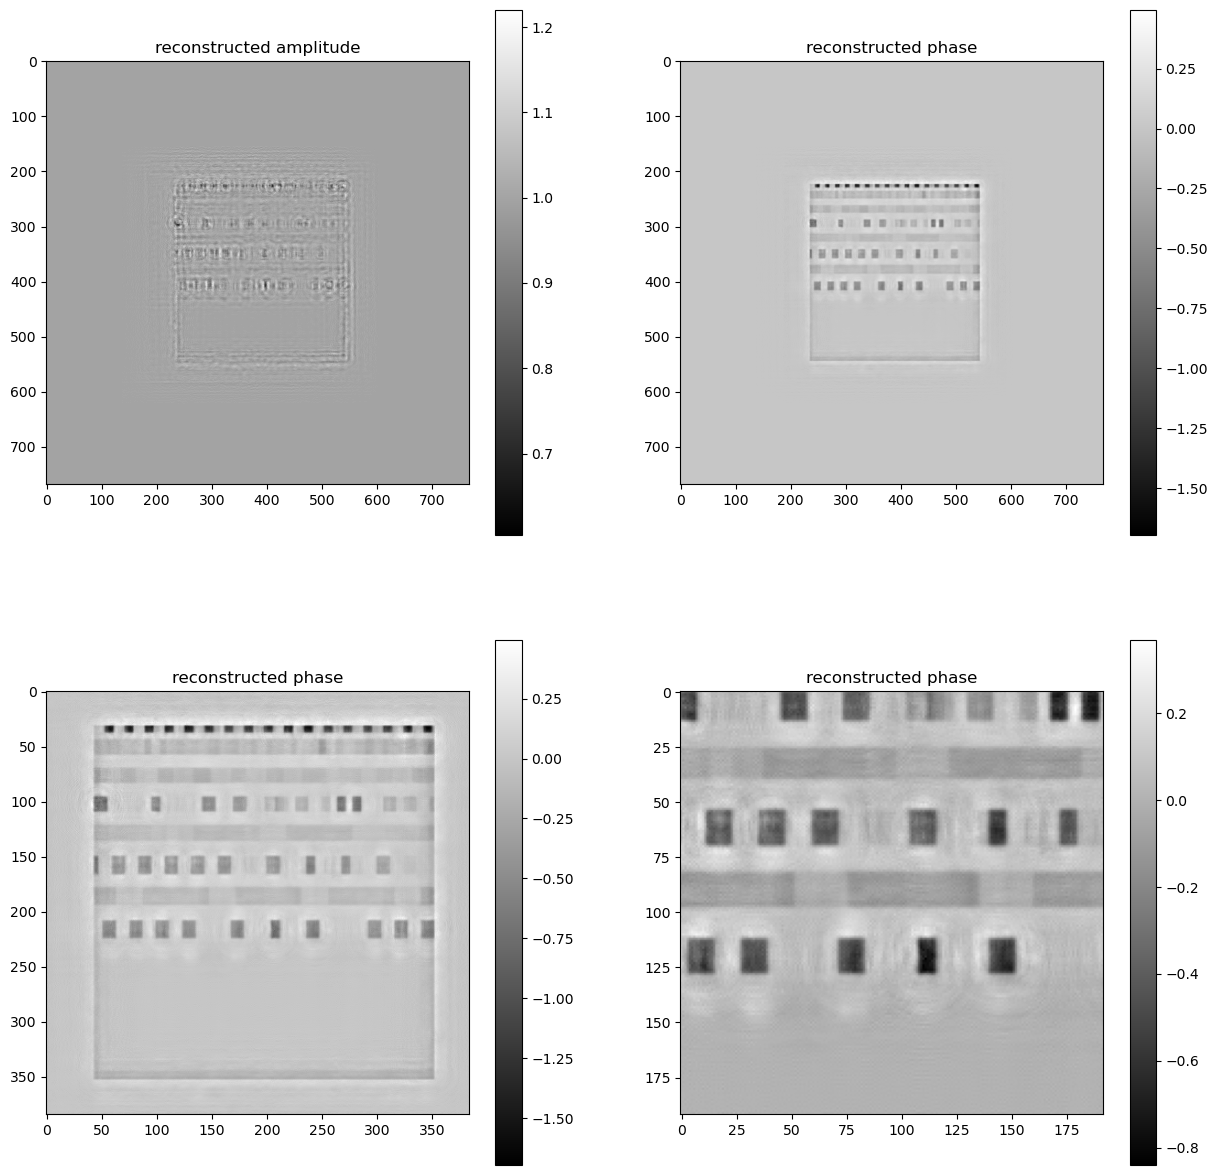

288) gammapsi=1, err=1.13301e+05
288) gammaprb=1, err=1.13119e+05
320) gammapsi=1, err=9.85408e+04
320) gammaprb=1, err=9.83962e+04
352) gammapsi=1, err=8.69664e+04
352) gammaprb=1, err=8.68490e+04
384) gammapsi=1, err=7.76905e+04
384) gammaprb=1, err=7.75932e+04
416) gammapsi=1, err=7.01116e+04
416) gammaprb=1, err=7.00295e+04
448) gammapsi=1, err=6.38165e+04
448) gammaprb=1, err=6.37462e+04
480) gammapsi=1, err=5.85140e+04
480) gammaprb=1, err=5.84531e+04
512) gammapsi=1, err=5.39927e+04
512) gammaprb=1, err=5.39395e+04


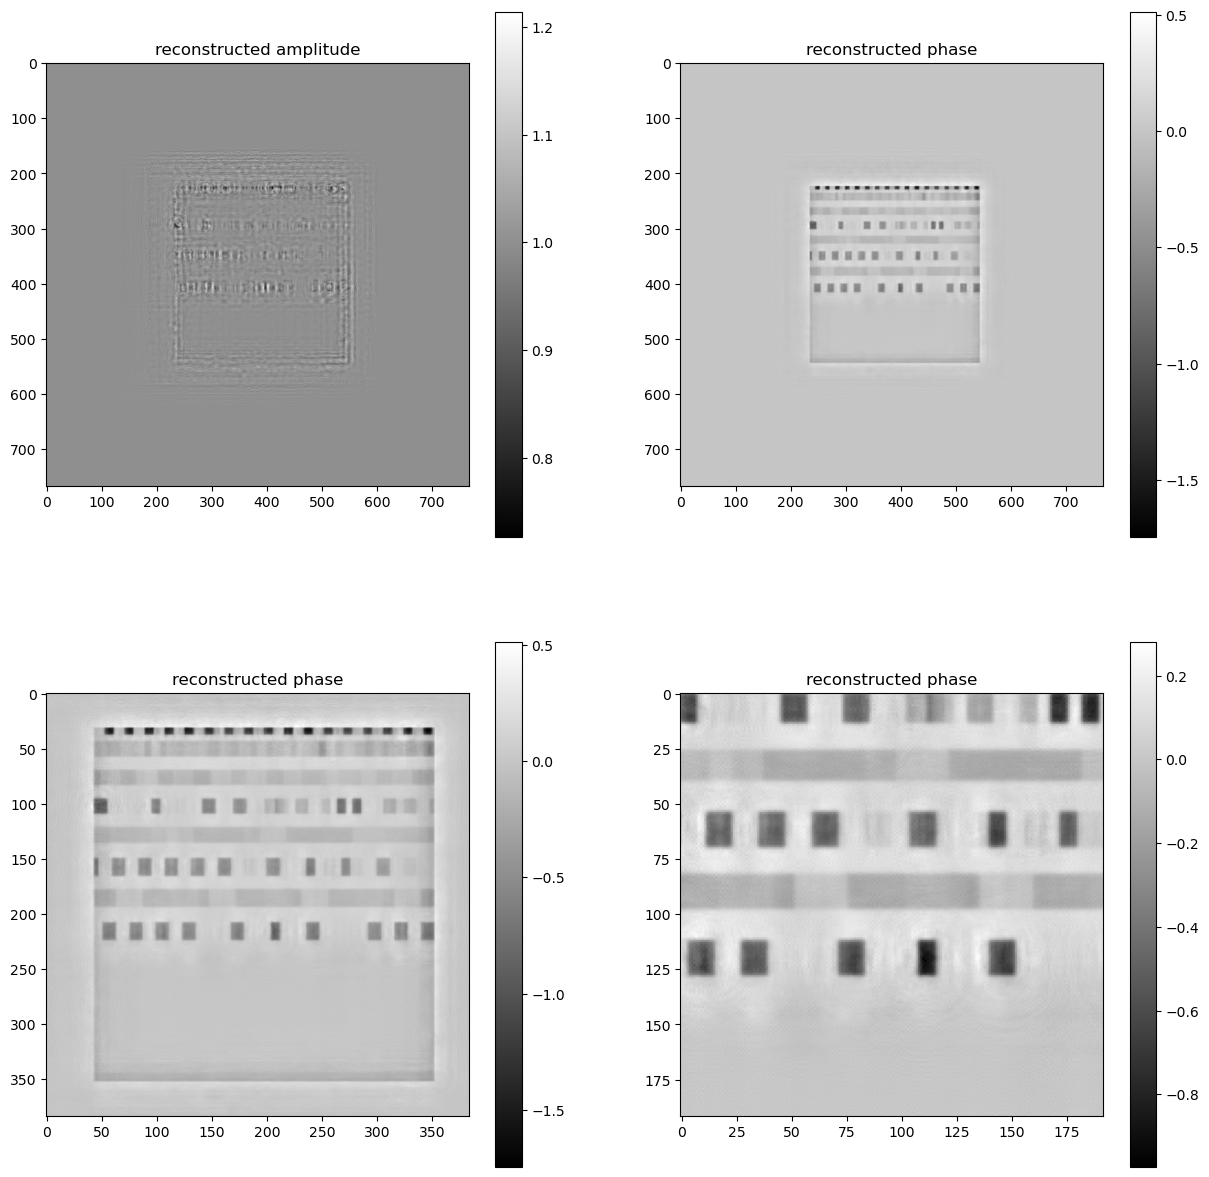

544) gammapsi=1, err=5.00985e+04
544) gammaprb=1, err=5.00517e+04
576) gammapsi=1, err=4.67139e+04
576) gammaprb=1, err=4.66724e+04
608) gammapsi=1, err=4.37471e+04
608) gammaprb=1, err=4.37100e+04
640) gammapsi=1, err=4.11258e+04
640) gammaprb=1, err=4.10925e+04
672) gammapsi=1, err=3.87944e+04
672) gammaprb=1, err=3.87643e+04
704) gammapsi=1, err=3.67081e+04
704) gammaprb=1, err=3.66808e+04
736) gammapsi=1, err=3.48302e+04
736) gammaprb=1, err=3.48053e+04
768) gammapsi=1, err=3.31312e+04
768) gammaprb=1, err=3.31084e+04


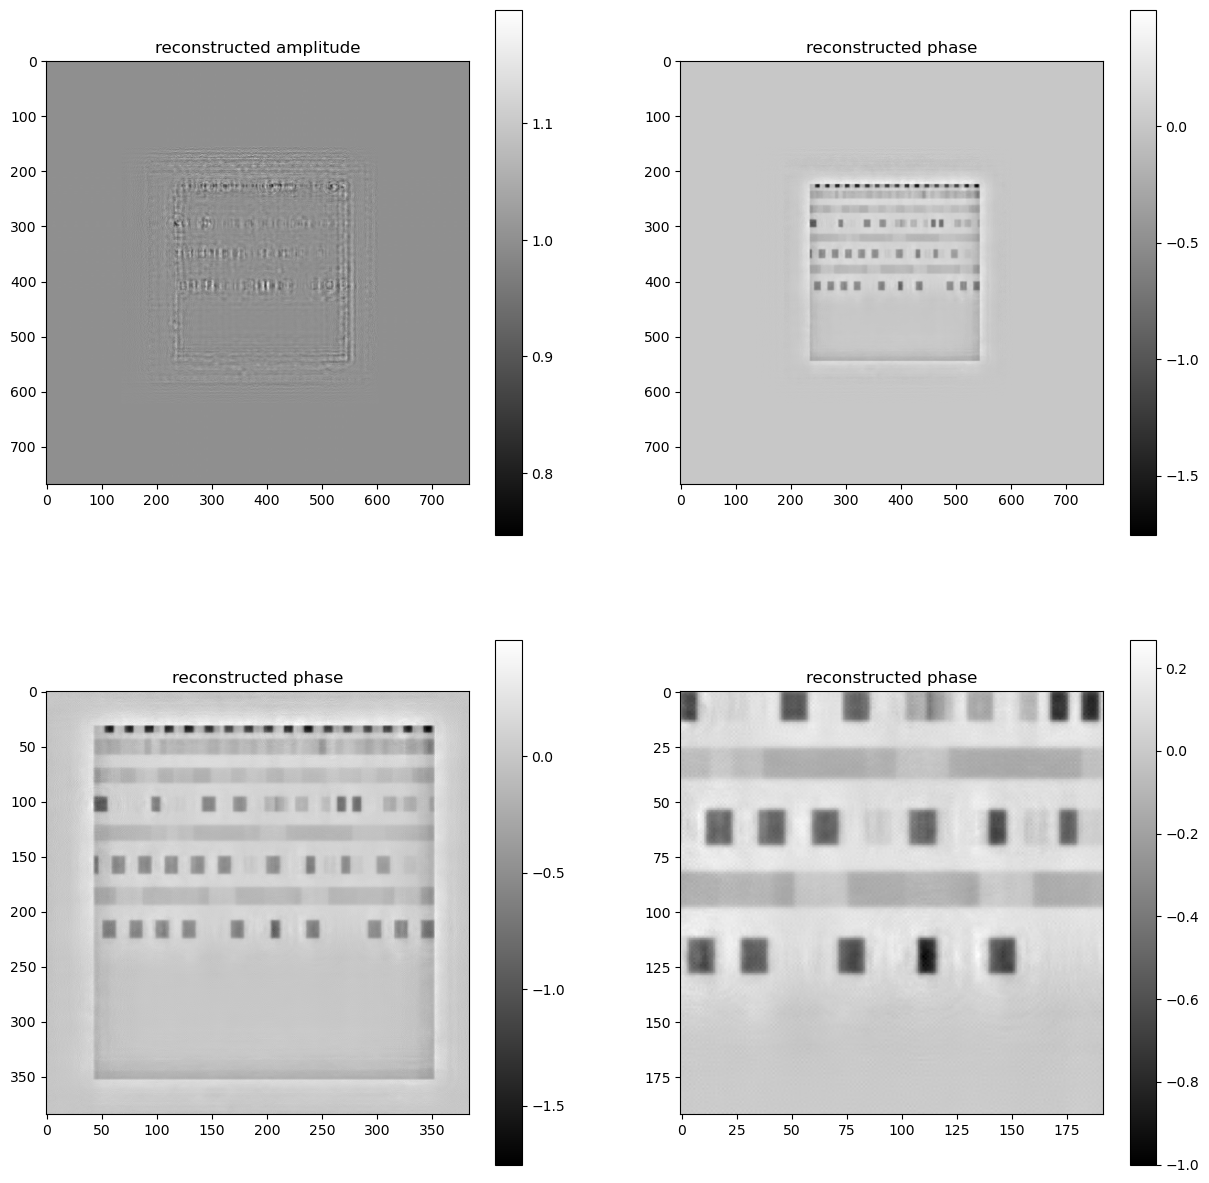

800) gammapsi=1, err=3.15868e+04
800) gammaprb=1, err=3.15659e+04
832) gammapsi=1, err=3.01770e+04
832) gammaprb=1, err=3.01578e+04
864) gammapsi=1, err=2.88853e+04
864) gammaprb=1, err=2.88675e+04
896) gammapsi=1, err=2.76973e+04
896) gammaprb=1, err=2.76808e+04
928) gammapsi=1, err=2.66009e+04
928) gammaprb=1, err=2.65855e+04
960) gammapsi=1, err=2.55864e+04
960) gammaprb=1, err=2.55721e+04
992) gammapsi=1, err=2.46450e+04
992) gammaprb=1, err=2.46316e+04
1024) gammapsi=1, err=2.37690e+04
1024) gammaprb=1, err=2.37565e+04


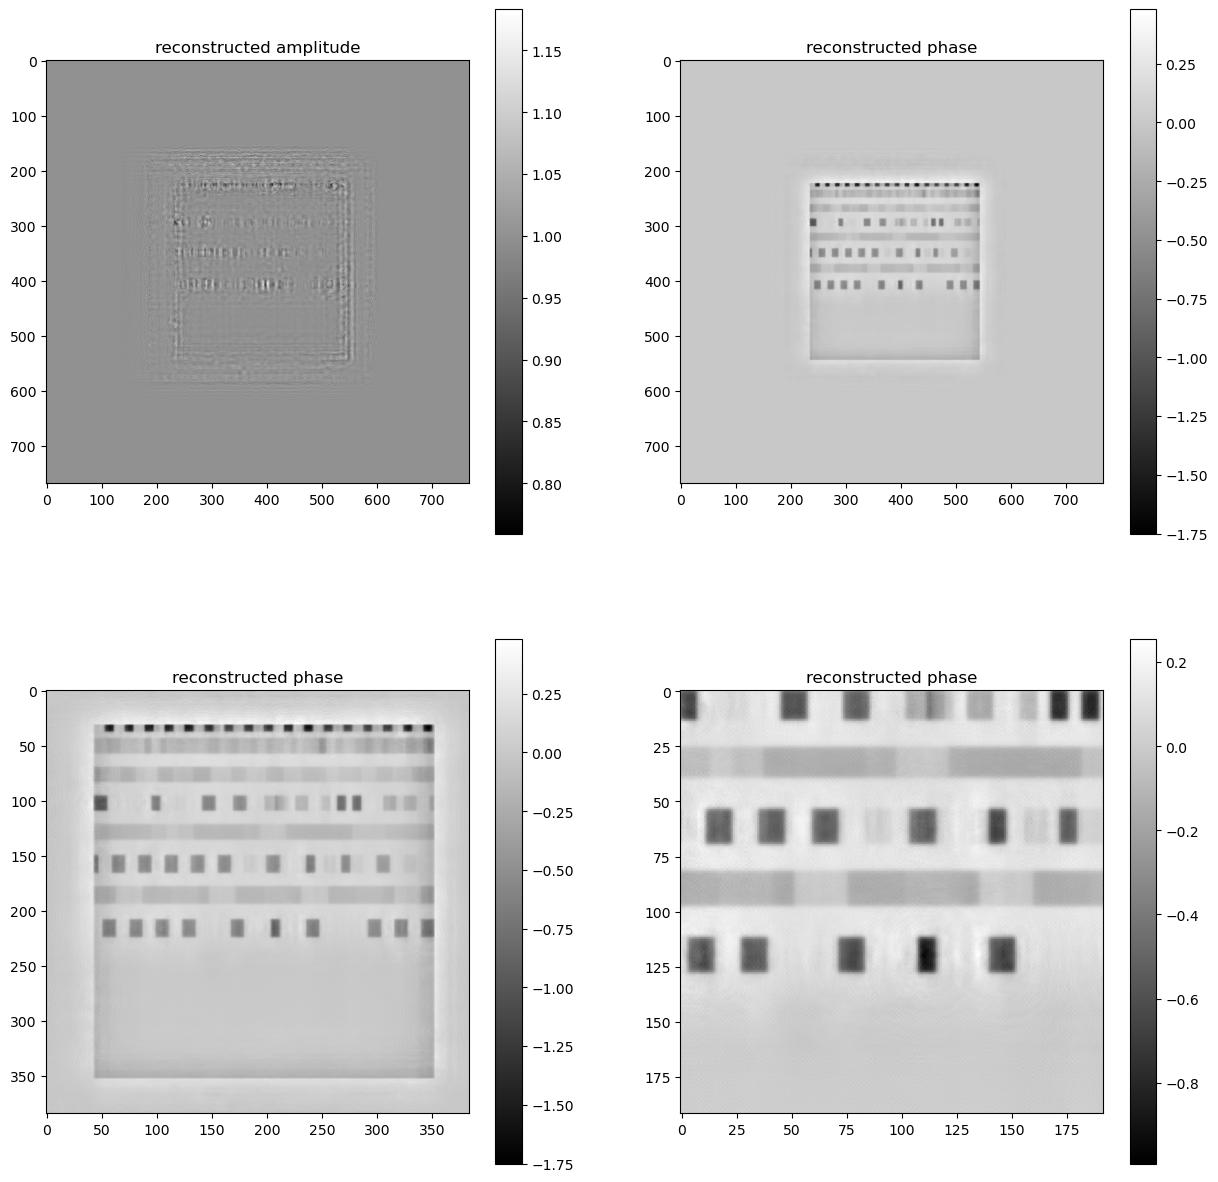

In [8]:

pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications, distances2) 
rec = np.ones([ntheta,2*n,2*n],dtype='complex64')
shifts_rec = cp.array(shifts/norm_magnifications[:,np.newaxis,np.newaxis])
print(data.shape,rec.shape,shifts.shape,norm_magnifications.shape)
rec,rec_prb = cg_holo_batch(pslv, data, rec, rec_prb, 1025, shifts_rec, True,True,32,256)

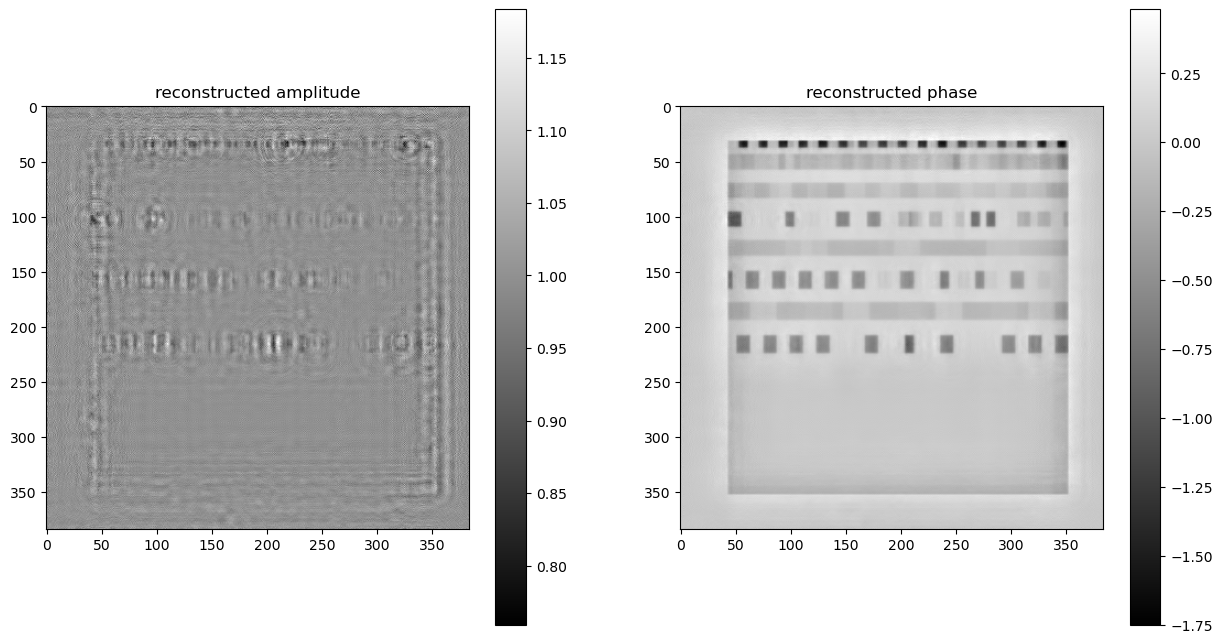

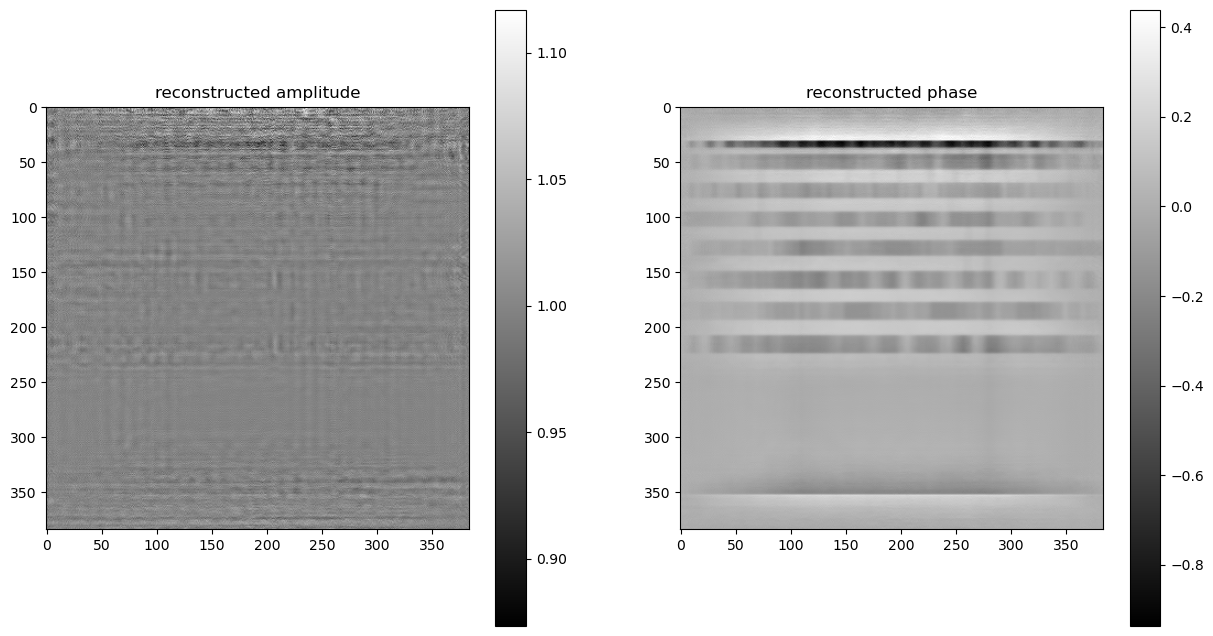

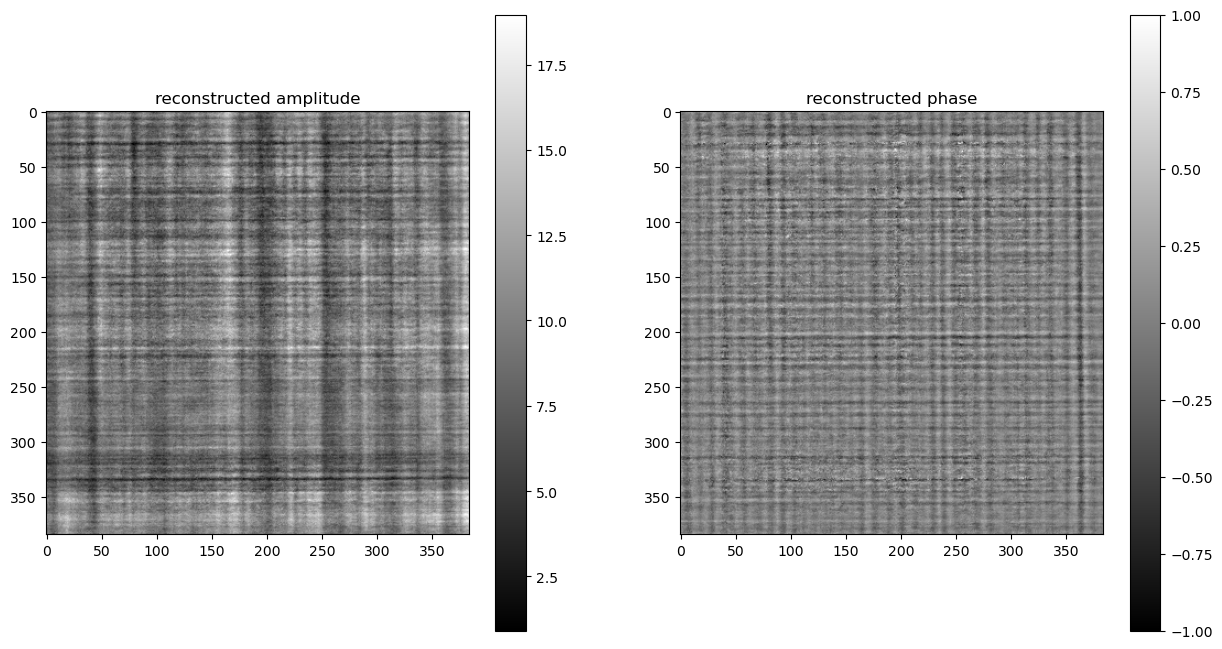

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(rec[0,n//2:-n//2,n//2:-n//2]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec[0,n//2:-n//2,n//2:-n//2]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(rec[ntheta//8,n//2:-n//2,n//2:-n//2]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec[ntheta//8,n//2:-n//2,n//2:-n//2]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(rec_prb[0]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec_prb[0]),cmap='gray',vmin=-1,vmax=1)
axs[1].set_title('reconstructed phase')
fig.colorbar(im)



# Convert the recovered transmittance function to the complex refractive index: $-\frac{i \lambda}{2\pi} \log(\psi)$  

In [10]:
projrec = pslv.logtomo(rec)

# Show sinogram

(180, 768, 768)


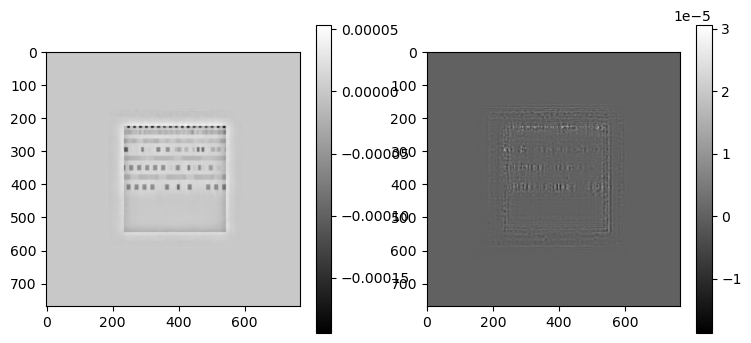

In [11]:
print(projrec.shape)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.real(projrec[0]),cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(np.imag(projrec[0]),cmap='gray')
fig.colorbar(im)

## Step 1. $\sum_i\sum_j||\mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_j S_{r_{ij}}\psi_i))|-\sqrt{\text{I}_{ij}}\|^2_2\to \text{min}_{\psi_i,q} $
$i$ - index for angles\
$j$ - index for planes \
$\psi$ - sample at plane 0 \
$q$ - probe at plane 0\
$M_j$ - object normalized (de-)magnification for the plane $j$ \
$S_r$ - shift for distance r (x and y), shifts between angles + alignment shifts \
$\mathcal{G}_d$ - Fresnel transform for distance $d$

## Step 2.  $\sum_i\|\mathcal{R}_i u-\frac{\text{i} \lambda}{2\pi} \log(\psi_i)\|^2_2\to\text{min}_u$  
$\mathcal{R}_i$ - Radon transform wrt angle i\

$u = 1-\delta_0+\beta \to  u = \delta+\beta$


In [12]:
with holotomo.SolverTomo(theta, ntheta, 2*n, 2*n, 2*64, 2*center) as tslv:
    init = np.zeros([2*n,2*n,2*n],dtype='complex64')
    piter = 64
    urec = tslv.cg_tomo_batch(projrec,init,piter)

0) gamma=1, err=1.4755745496586314e-06
1) gamma=1, err=1.4544086752721341e-06
2) gamma=1, err=1.4164787671688828e-06
3) gamma=1, err=1.3521870414479054e-06
4) gamma=1, err=1.1474410257505951e-06
5) gamma=1, err=1.042361304826045e-06
6) gamma=1, err=8.792850962890952e-07
7) gamma=1, err=7.20296611689264e-07
8) gamma=1, err=6.3335750155602e-07
9) gamma=1, err=5.930924658059666e-07
10) gamma=1, err=4.929015062771214e-07
11) gamma=1, err=4.793518542101083e-07
12) gamma=1, err=4.345855586507241e-07
13) gamma=1, err=4.19692554487483e-07
14) gamma=1, err=4.0606815332466795e-07
15) gamma=1, err=3.9340000057563884e-07
16) gamma=1, err=3.8357336507033324e-07
17) gamma=1, err=3.7914202266620123e-07
18) gamma=1, err=3.5942434806202073e-07
19) gamma=1, err=3.5681338772519666e-07
20) gamma=1, err=3.524052942793787e-07
21) gamma=1, err=3.480994621440914e-07
22) gamma=1, err=3.4478782140467956e-07
23) gamma=1, err=3.4293933026674495e-07
24) gamma=1, err=3.373345975887787e-07
25) gamma=1, err=3.3617135

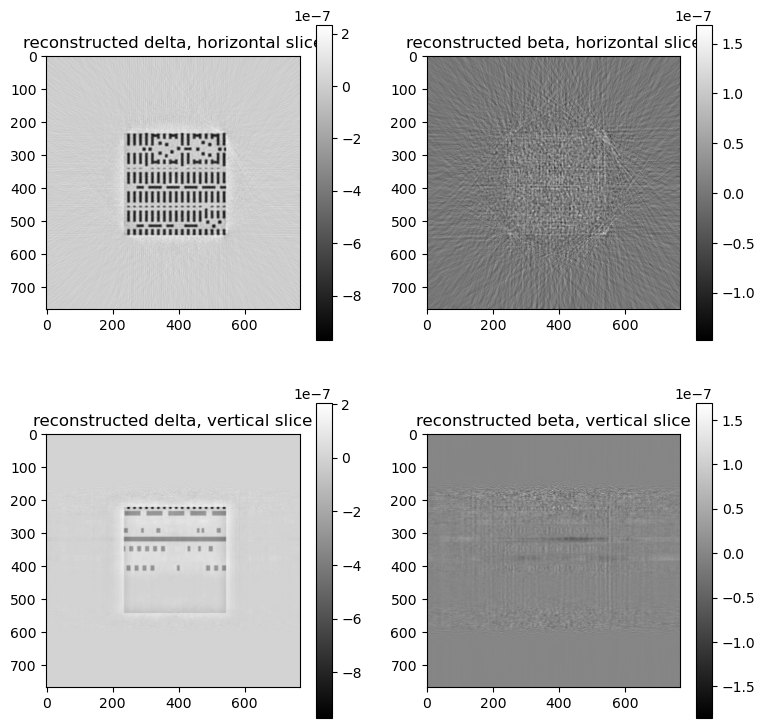

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(urec[227].real,cmap='gray')
axs[0,0].set_title('reconstructed delta, horizontal slice')
fig.colorbar(im)
im=axs[0,1].imshow(urec[227].imag,cmap='gray')
axs[0,1].set_title('reconstructed beta, horizontal slice')
fig.colorbar(im)
im=axs[1,0].imshow(urec[:,n].real,cmap='gray')
axs[1,0].set_title('reconstructed delta, vertical slice')
fig.colorbar(im)
im=axs[1,1].imshow(urec[:,n].imag,cmap='gray')
axs[1,1].set_title('reconstructed beta, vertical slice')
fig.colorbar(im)

In [14]:

dxchange.write_tiff(urec.real,f'/data/vnikitin/holo/urec_chip_re{n}_{ntheta}_{ndist}',overwrite=True)
dxchange.write_tiff(urec.imag,f'/data/vnikitin/holo/urec_chip_im{n}_{ntheta}_{ndist}',overwrite=True)

dxchange.write_tiff(np.abs(rec),f'/data/vnikitin/holo//psirec_chip_abs{n}_{ntheta}_{ndist}',overwrite=True)
dxchange.write_tiff(np.angle(rec),f'/data/vnikitin/holo/psirec_chip_angle{n}_{ntheta}_{ndist}',overwrite=True)

dxchange.write_tiff(np.abs(rec_prb),f'/data/vnikitin/holo/prbrec_chip_abs{n}_{ntheta}_{ndist}',overwrite=True)
dxchange.write_tiff(np.angle(rec_prb),f'/data/vnikitin/holo/prbrec_chip_angle{n}_{ntheta}_{ndist}',overwrite=True)
